# Calculation of Mean and Covariance

April 20, 2022

The goal of this notebook is to compare simulations with analytic expressions derived by Christian Schmid.

We start with a very general RNN equation with driving input:

$$ \frac{d}{dt}h(t) = W h(t) + \tilde{W} \int_0^t h(s) ds + x + \sigma \xi $$

By introducing $H(t) = \int_0^t h(s) ds$, this equation becomes an Ornstein Uhlenbech process for $\mathbf{H}(t) = \begin{pmatrix} H(t) \\ h(t) \end{pmatrix} $

           

$$ d\mathbf{H}(t) = \boldsymbol\Theta \big( \boldsymbol\mu - \mathbf{H}(t) \big) dt + \boldsymbol\sigma dW $$

Skipping a few steps, we can write the solution as an Ito integral and find the characteristic function

$$ \phi(\mathbf{u}, t) = \mathrm{exp} \big[ i \mathbf{u}^\top (\boldsymbol\mu + e^{-\boldsymbol \Theta t}(\mathbf{H}_0 - \boldsymbol \mu) ) - \frac{1}{2} \mathbf{u}^\top \big( \int_0^t e^{\boldsymbol\Theta(s-t)} \mathbf{D} e^{\boldsymbol \Theta^\top(s-t)} ds \big) \mathbf{u}    \big] $$

Here the mean is

$$ \boldsymbol \mu(t) = \boldsymbol\mu + e^{-\boldsymbol \Theta t}(\mathbf{H}_0 - \boldsymbol \mu)  $$ 

when H0=0, we have

$$ \boldsymbol \mu(t) = (1-e^{-\boldsymbol \Theta t}) \boldsymbol\mu $$

and the covariance is

$$ \int_0^t e^{\boldsymbol\Theta(s-t)} \mathbf{D} e^{\boldsymbol \Theta^\top(s-t)} ds$$

where the diffusion operator is $\mathbf{D}=\boldsymbol \sigma \boldsymbol \sigma^\top$

In scenario where $W^{fb} = 0$ and the noise to zero ($\sigma=0$), we have a much simpler expression, 

$$ \frac{d}{dt}h(t) = W h(t)  + x $$

we no longer work with $2N$ dimensions, we can replace $ \mu = -W^{-1}x$ and $\Theta = -W$

$$ \mu(t) = (-1+e^{Wt}) W^{-1}x$$

The covariance will look something like:

$$ \textrm{cov}(h(t)) = \int_0^t  e^{-W(s-t)} \sigma \sigma^\top e^{-W^\top (s-t)} dt$$

----

TO DO:
* We want to check that the choice of dt doesn't matter (provided dt is small enough). We want `n_steps*dt = constant`
* As an aside, one way to check if discretization is correct is to _halve_ the dt and _double_ the simulation time, and get the same result

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories

In [3]:
# define f and df

def f_linear(x):
    return x

def df_linear(x):
    return 1

### Train RNN on four targets using RFLO

In [4]:
trial_duration = 60
n_in=4
frac_on = 1

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

## 1. Training `w_rec` only using RFLO, with velocity transformation

Note that I also had to change the code in the following lines of the RFLO algorithm

```
if 'w_rec' in self.apply_to: 
    self.p = (1-rnn.dt/rnn.tau_rec)*self.p
    self.p += np.outer(rnn.df(rnn.u), rnn.h_prev)*rnn.dt/rnn.tau_rec
if 'w_in' in self.apply_to:
    self.q = (1-rnn.dt/rnn.tau_rec)*self.q
    self.q += np.outer(rnn.df(rnn.u), rnn.x_in_prev)*rnn.dt/rnn.tau_rec  
if 'w_fb' in self.apply_to:
    self.p_fb = (1-rnn.dt/rnn.tau_rec)*self.p_fb
    self.p_fb += np.outer(rnn.df(rnn.u), rnn.pos)*rnn.dt/rnn.tau_rec
```

In [5]:
0.01/0.005

2.0

1it [00:00,  6.26it/s]

n_in: 4
n_rec: 110
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.0
tau_rec: 1
dt: 0.01
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 0.1
g_out: 2.0
g_fb: 1.0
driving_feedback: True
eta_fb: 0.0
sig_fb: 0.0
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fe57f5203f0>
>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


100it [00:01, 81.43it/s]


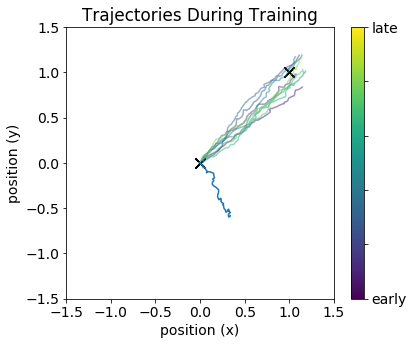

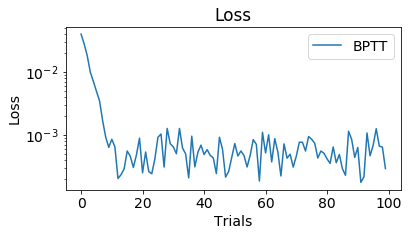

In [133]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=110,n_out=2,tau_rec=1,dt = 0.01, # note that tau_rec and dt are anticorrelated
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.0,
               sig_in=0.0,sig_rec=1*np.sqrt(0.01),sig_out=0.0,sig_fb=0.0,
               g_rec=0.1,g_fb=1.0,
               velocity_transform=False,
               driving_feedback=True,
               rng=np.random.RandomState(27))

params.print_params()

# Initialize RNN
net = RNN(params,f=f_linear,df=df_linear)
#net.set_weights(w_fb=0*net.w_fb)
#print('set wfb=0')
# initialize simulation
sim = Simulation(net)

bptt = BPTT(net,apply_to=['w_rec','w_out'])

sim.run_session(n_trials=100, tasks=[task1], learn_alg=[bptt], probe_types=['h'], plot=True, plot_freq=10)


100it [00:00, 200.92it/s]


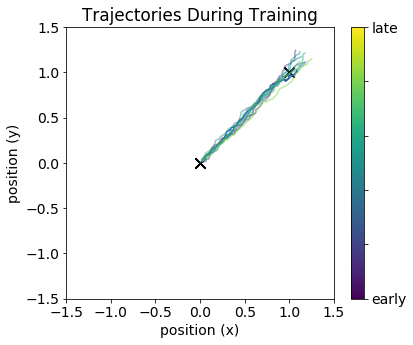

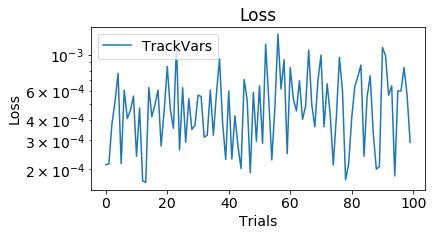

In [134]:
trackvars = TrackVars(net,apply_to=[])

sim.run_session(n_trials=100, tasks=[task1], learn_alg=[trackvars], probe_types=['h','pos'], plot=True, plot_freq=10)

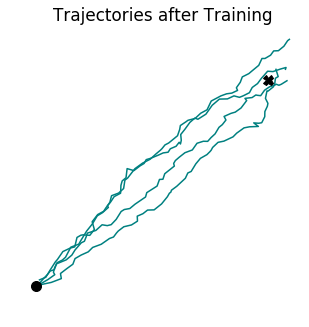

In [135]:
fig = plot_trained_trajectories(sim=sim, tasks=[task1])


What we want to do now is compare _simulated_ mean activity with the analytic expression for mean activity

## Calculate Analytic Mean

In [136]:
def calculate_analytic_mean(net,task,sim,t,feedback=True):
    
    """
    The expression for the mean activity at time t is...
    
        mu + np.exp(theta * t) (H0 - mu)
        
    Note that we use the scipy pseudoinverse for stability
        
    TO DO:
    t should be converted to step size
    """
    
    steps = np.arange(1,task.trial_duration) # note index starts at 1 here
    
    assert t < task.trial_duration*net.dt, 'time must be less than trial duration'
    assert np.around(t/net.dt,decimals=10) in steps, 'time must be a multiple of net.dt'
    
    t_ind = np.where(np.around(t/net.dt,decimals=10)==steps)[0][0]
    
    #activity = sim.session_probes['h'] # get history of activity during trial
    
    if feedback:
        """ Full scenario with feedback and noise """
        print('>> Assuming Feedback Matrix')
    
        # check this negative sign
        mu_1 = -1.0*LA.pinv2(net.w_fb @ net.w_out) @ (net.w_in @ task1.x_in.T) # scipy pseudo inverse, shape (neurons, timesteps)
        mu_2 = np.zeros(mu_1.shape)

        mu = np.concatenate((mu_1[:,t_ind],mu_2[:,t_ind]),axis=0) # only select at time t, resulting in shape (2*neurons,)

        theta_11 = np.zeros(net.w_rec.shape)
        theta_12 = -np.eye(net.w_rec.shape[0],net.w_rec.shape[1])
        theta_21 = -net.w_fb @ net.w_out # (neurons,neurons)
        theta_22 = -net.w_rec # (neurons,neurons)

        """ construct THETA matrix """
        # stack four matrices
        # final matrix should be shape (2*neurons,2*neurons)
        theta_A = np.concatenate((theta_11, theta_12), axis=1)
        theta_B = np.concatenate((theta_21, theta_22), axis=1)
        theta = np.concatenate((theta_A,theta_B),axis=0)

        # ignore H0 for now
        #H0_1 = net.h0.squeeze() #np.sum(activity) * net.dt # sum of activity, but for initial condition will be zero
        #H0_2 = net.h0.squeeze() # activity at time t
        
        # 
        activity = np.mean(np.asarray(sim.session_probes['h']),axis=0).squeeze()
        H0_1 = activity[0,:].squeeze() # (timesteps, # neurons)
        H0_2 = activity[0,:].squeeze()
        
        H = np.concatenate((H0_1,H0_2),axis=0)

        analytic_mean = mu + LA.expm(-theta*t) @ (H - mu)
    
    
    else:
        """ Simple case with no feedback and no noise """
        print('>> No driving feedback')
        
        analytic_mean = (-1 + LA.expm(net.w_rec * t)) @ LA.pinv2(net.w_rec) @ (net.w_in @ task1.x_in[t_ind])
        
        
    return analytic_mean

In [137]:
print('net dt: {}'.format(net.dt))
print('duration: {}'.format(task1.trial_duration * net.dt))

net dt: 0.01
duration: 0.6


>> Assuming Feedback Matrix
time t=0.2, t_ind=19

>> feedback


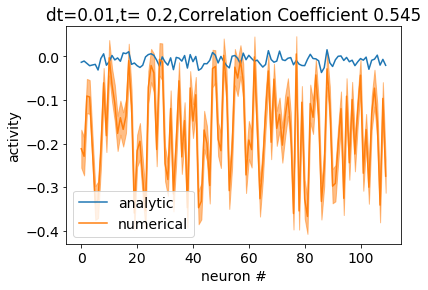

In [138]:
feedback = True

t = 0.2
analytic_mean = calculate_analytic_mean(net,task1,sim,t=t,feedback=feedback)
#analytic_mean = calculate_analytic_mean(net,task1,sim,t=t,feedback=True)

steps = np.arange(1,task1.trial_duration) # note index starts at 1 here
    
assert t < task1.trial_duration*net.dt, 'time must be less than trial duration'
assert np.around(t/net.dt,decimals=10) in steps, 'time must be a multiple of net.dt'
    
t_ind = np.where(np.around(t/net.dt,decimals=10)==steps)[0][0] 
print('time t={}, t_ind={}'.format(t,t_ind))


av_activity = np.mean(np.asarray(sim.session_probes['h']),axis=0).squeeze()
activity = av_activity[t_ind,:] # (timesteps, # neurons)
activity_std = np.std(np.asarray(sim.session_probes['h']),axis=0).squeeze()[t_ind,:]

""" assuming feedback """
if feedback==True:
    print('\n>> feedback')
    corr = np.corrcoef(analytic_mean[net.n_rec:],activity)[0,1]
    plt.plot(analytic_mean[net.n_rec:],label='analytic')

""" no feedback """
if feedback==False:
    print('>> no feedback')
    corr = np.corrcoef(analytic_mean,activity)[0,1]
    plt.plot(analytic_mean,label='analytic')
    
plt.plot(activity,label='numerical')
plt.fill_between(np.arange(0,len(activity)),activity-activity_std,activity+activity_std,alpha=0.5,color='C1')
plt.xlabel('neuron #')
plt.ylabel('activity')
plt.title('dt={},t= {},Correlation Coefficient {:.3f}'.format(net.dt,t,corr))
plt.legend()
plt.show()

## Calculate Analytic Covariance

The expression should look something like 

$$ \textrm{cov}(h(t)) = \int_0^t  e^{-W(s-t)} \sigma \sigma^\top e^{-W^\top (s-t)} dt$$


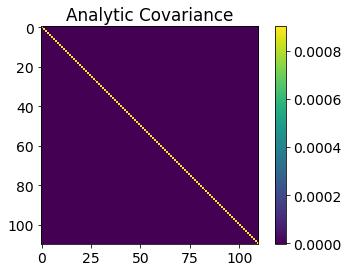

In [139]:
sigma = net.sig_rec*np.eye(net.w_rec.shape[0],net.w_rec.shape[1])

sigma_squared = sigma @ sigma.T

t = 0.1
all_times = np.arange(net.dt,t,net.dt) # or maybe start with net.dt

total = []
#this could be done more efficiently
for s in all_times:
    term1 = LA.expm(-net.w_rec * (s-t))
    
    term2 = LA.expm(-net.w_rec.T * (s-t))
    
    total.append(term1 @ sigma_squared @ term2 * net.dt)

cov_analytic = np.sum(np.asarray(total),axis=0)
    
#cov_analytic = term1 @ sigma_squared @ term2
# cov_analytic = sigma_squared
# cov_analytic = net.w_rec @ net.w_rec.T
    


plt.imshow(cov_analytic)
plt.colorbar()
plt.title('Analytic Covariance')
plt.show()




In [140]:
cov_analytic

array([[ 8.99733733e-04,  3.42236793e-07, -8.55009548e-07, ...,
        -5.18601413e-07,  4.55585029e-07, -3.00873525e-08],
       [ 3.42236793e-07,  9.00616188e-04, -4.99281991e-08, ...,
         7.06394902e-07,  1.88131911e-07, -6.09928237e-07],
       [-8.55009548e-07, -4.99281991e-08,  8.99054184e-04, ...,
         1.80539806e-07,  3.23661987e-07, -5.80747860e-07],
       ...,
       [-5.18601413e-07,  7.06394902e-07,  1.80539806e-07, ...,
         8.99630618e-04, -4.66816211e-07,  3.01649659e-07],
       [ 4.55585029e-07,  1.88131911e-07,  3.23661987e-07, ...,
        -4.66816211e-07,  9.00970310e-04, -3.68859203e-07],
       [-3.00873525e-08, -6.09928237e-07, -5.80747860e-07, ...,
         3.01649659e-07, -3.68859203e-07,  8.98418442e-04]])

time t=0.5, t_ind=49


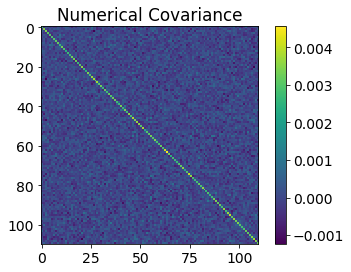

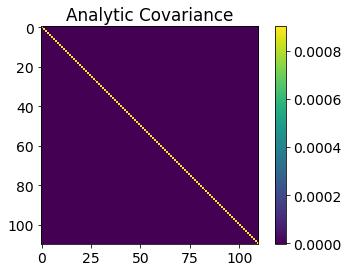

correlation between matrices: 0.684696
correlation between matrices: 0.999975


In [141]:
""" Compare to Measured Covariance """

t = 0.5

steps = np.arange(1,task1.trial_duration) # note index starts at 1 here
    
assert t < task1.trial_duration*net.dt, 'time must be less than trial duration'
assert np.around(t/net.dt,decimals=10) in steps, 'time must be a multiple of net.dt'
    
t_ind = np.where(np.around(t/net.dt,decimals=10)==steps)[0][0] 
print('time t={}, t_ind={}'.format(t,t_ind))


all_activity = np.asarray(sim.session_probes['h']).squeeze() # trials x steps x neurons
activity = all_activity[:,t_ind,:] # (timesteps, # neurons)
#cov_numerical  = (activity.T @ activity) / np.sqrt(activity.shape[0]) # dont forget product of the means

cov_numerical = np.cov(activity.T)

plt.imshow(cov_numerical)
plt.colorbar()
plt.title('Numerical Covariance')
plt.show()

plt.imshow(cov_analytic)
plt.colorbar()
plt.title('Analytic Covariance')
plt.show()

C = np.corrcoef(cov_analytic.ravel(),cov_numerical.ravel())
print('correlation between matrices: {:.6f}'.format(C[0,1]))

C = np.corrcoef(cov_analytic.ravel(),np.eye(cov_analytic.shape[0],cov_analytic.shape[1]).ravel())
print('correlation between Analytic Covariance and Identity matrix: {:.6f}'.format(C[0,1]))

time t=0.1, t_ind=9


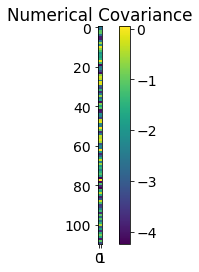

In [123]:
""" Looking at correlation of Cursor Position """

""" Compare to Measured Covariance """

t = 0.1

steps = np.arange(1,task1.trial_duration) # note index starts at 1 here
    
assert t < task1.trial_duration*net.dt, 'time must be less than trial duration'
assert np.around(t/net.dt,decimals=10) in steps, 'time must be a multiple of net.dt'
    
t_ind = np.where(np.around(t/net.dt,decimals=10)==steps)[0][0] 
print('time t={}, t_ind={}'.format(t,t_ind))


all_activity = np.asarray(sim.session_probes['h']).squeeze() # trials x steps x neurons
activity = all_activity[:,t_ind,:] # (timesteps, # neurons)

all_positions = np.asarray(sim.session_probes['pos']).squeeze() # trials x steps x pos
positions = all_positions[:,t_ind,:] # (timesteps, # xy position)

#cov_numerical  = (activity.T @ activity) / np.sqrt(activity.shape[0]) # dont forget product of the means

cov_numerical = activity.T @ positions - np.mean(activity.T)* np.mean(positions)

plt.imshow(cov_numerical)
plt.colorbar()
plt.title('Numerical Covariance')
plt.show()

In [88]:
cov_numerical

array([[-2.57404419e+00, -2.42296151e+00],
       [-2.74850641e+00, -2.59070475e+00],
       [-1.10958693e+00, -1.04560830e+00],
       [-1.12064211e+00, -1.05509394e+00],
       [-2.79876090e+00, -2.63898959e+00],
       [-4.10451374e+00, -3.87113102e+00],
       [-4.14233233e+00, -3.90726940e+00],
       [-2.56272801e+00, -2.41420986e+00],
       [-6.40750029e-01, -6.04778428e-01],
       [-2.26823115e+00, -2.13728629e+00],
       [-1.32527487e-01, -1.23270897e-01],
       [-7.04960429e-01, -6.66467863e-01],
       [-1.30421409e+00, -1.23000660e+00],
       [-2.13892786e+00, -2.01422319e+00],
       [-1.77939054e+00, -1.67365316e+00],
       [-1.86669149e+00, -1.76043270e+00],
       [-1.46702530e+00, -1.38053498e+00],
       [-6.00156921e-02, -5.10968420e-02],
       [-1.47576390e+00, -1.39176056e+00],
       [-4.39746277e+00, -4.14469387e+00],
       [-2.74501275e+00, -2.58899102e+00],
       [-2.43418263e+00, -2.29546123e+00],
       [-3.45593773e+00, -3.26135166e+00],
       [-4.

In [83]:
all_positions.shape

(100, 60, 2)

In [82]:
activity.T.shape

(110, 100)

In [81]:
np.cov??

Signature:
np.cov(
    ['m', 'y=None', 'rowvar=True', 'bias=False', 'ddof=None', 'fweights=None', 'aweights=None'],
)
Source:   
def cov(m, y=None, rowvar=True, bias=False, ddof=None, fweights=None,
        aweights=None):
    """
    Estimate a covariance matrix, given data and weights.

    Covariance indicates the level to which two variables vary together.
    If we examine N-dimensional samples, :math:`X = [x_1, x_2, ... x_N]^T`,
    then the covariance matrix element :math:`C_{ij}` is the covariance of
    :math:`x_i` and :math:`x_j`. The element :math:`C_{ii}` is the variance
    of :math:`x_i`.

    See the notes for an outline of the algorithm.

    Parameters
    ----------
    m : array_like
        A 1-D or 2-D array containing multiple variables and observations.
        Each row of `m` represents a variable, and each column a single
        observation of all those variables. Also see `rowvar` below.
    y : array_like, optional
        An additional set of variables and 

# Experiment 1 - Matching Calculation with Simulation with no feedback

3it [00:00, 29.22it/s]

n_in: 4
n_rec: 110
n_out: 2
sig_in: 0.0
sig_rec: 0.15811388300841897
sig_out: 0.0
tau_rec: 1
dt: 0.01
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 0.1
g_out: 2.0
g_fb: 2.0
driving_feedback: True
eta_fb: 0.0
sig_fb: 0.0
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb4d957f090>
>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


100it [00:01, 80.78it/s]
100it [00:00, 148.08it/s]


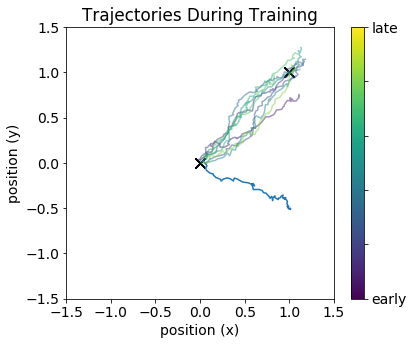

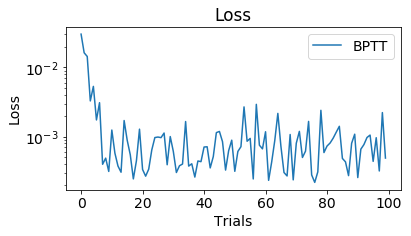

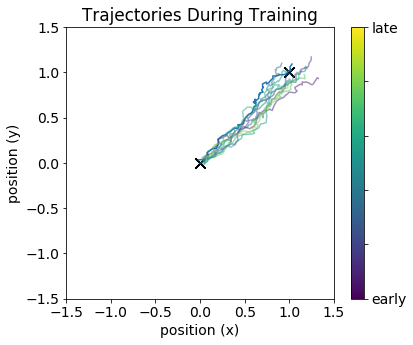

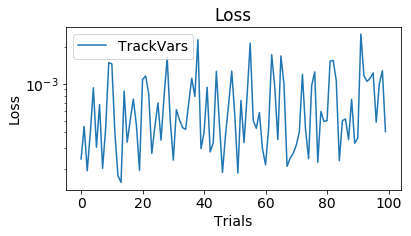

In [21]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=110,n_out=2,tau_rec=1,dt = 0.01, # note that tau_rec and dt are anticorrelated
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.0,
               sig_in=0.0,sig_rec=0.5*np.sqrt(0.1),sig_out=0.0,sig_fb=0.0,
               g_rec=0.1,
               velocity_transform=False,
               driving_feedback=True,
               rng=np.random.RandomState(1))

params.print_params()

# Initialize RNN
net = RNN(params,f=f_linear,df=df_linear)
#net.set_weights(w_fb=0*net.w_fb)
#print('set wfb=0')
# initialize simulation
sim = Simulation(net)

bptt = BPTT(net,apply_to=['w_rec','w_out'])

sim.run_session(n_trials=100, tasks=[task1], learn_alg=[bptt], probe_types=['h'], plot=True, plot_freq=10)

trackvars = TrackVars(net,apply_to=[])

sim.run_session(n_trials=100, tasks=[task1], learn_alg=[trackvars], probe_types=['h'], plot=True, plot_freq=10)

recurrent noise scale:  0.15811388300841897
recurrent initialization: g=0.1
>> No driving feedback
time t=0.01, t_ind=0
>> no feedback


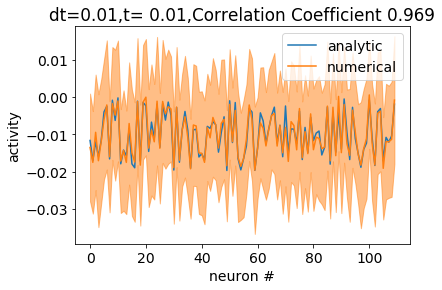

recurrent noise scale:  0.15811388300841897
recurrent initialization: g=0.1
>> No driving feedback
time t=0.1, t_ind=9
>> no feedback


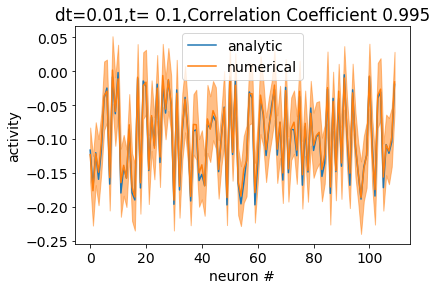

recurrent noise scale:  0.15811388300841897
recurrent initialization: g=0.1
>> No driving feedback
time t=0.5, t_ind=49
>> no feedback


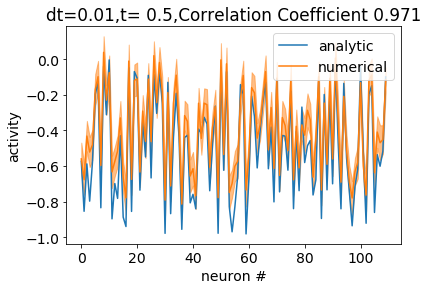

In [22]:
feedback = False

t = 0.5

for t in [0.01,0.1,0.5]:
    
    print('recurrent noise scale: ',net.sig_rec)
    print('recurrent initialization: g={}'.format(net.g_rec))
    analytic_mean = calculate_analytic_mean(net,task1,sim,t=t,feedback=feedback)

    steps = np.arange(1,task1.trial_duration) # note index starts at 1 here

    assert t < task1.trial_duration*net.dt, 'time must be less than trial duration'
    assert np.around(t/net.dt,decimals=10) in steps, 'time must be a multiple of net.dt'

    t_ind = np.where(np.around(t/net.dt,decimals=10)==steps)[0][0] 
    print('time t={}, t_ind={}'.format(t,t_ind))


    av_activity = np.mean(np.asarray(sim.session_probes['h']),axis=0).squeeze()
    activity = av_activity[t_ind,:] # (timesteps, # neurons)
    activity_std = np.std(np.asarray(sim.session_probes['h']),axis=0).squeeze()[t_ind,:]

    """ assuming feedback """
    if feedback==True:
        print('>> feedback')
        corr = np.corrcoef(analytic_mean[net.n_rec:],activity)[0,1]
        plt.plot(analytic_mean[net.n_rec:],label='analytic')

    """ no feedback """
    if feedback==False:
        print('>> no feedback')
        corr = np.corrcoef(analytic_mean,activity)[0,1]
        plt.plot(analytic_mean,label='analytic')

    plt.plot(activity,label='numerical')
    plt.fill_between(np.arange(0,len(activity)),activity-activity_std,activity+activity_std,alpha=0.5,color='C1')
    plt.xlabel('neuron #')
    plt.ylabel('activity')
    plt.title('dt={},t= {},Correlation Coefficient {:.3f}'.format(net.dt,t,corr))
    plt.legend()
    plt.show()

### This is pretty striking! What we can see here is that over the course of the simulation, the analytic and numerical predictions diverge slightly (but not that much)!

### Note that I have found this to be the case for g << 1

(110, 220)


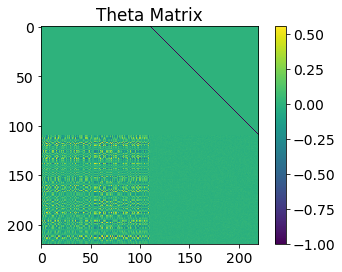

In [50]:
theta_11 = np.zeros(net.w_rec.shape)
theta_12 = -np.eye(net.w_rec.shape[0],net.w_rec.shape[1])
theta_21 = -net.w_fb @ net.w_out # (neurons,neurons)
theta_22 = -net.w_rec # (neurons,neurons)

""" construct THETA matrix """
# stack four matrices
# final matrix should be shape (2*neurons,2*neurons)
theta_A = np.concatenate((theta_11, theta_12), axis=1)
print(theta_A.shape)
theta_B = np.concatenate((theta_21, theta_22), axis=1)
theta = np.concatenate((theta_A,theta_B),axis=0)
plt.imshow(theta)
plt.colorbar()
plt.title('Theta Matrix')
plt.show()

In [81]:
feedback = True
task = task1

steps = np.arange(1,task.trial_duration) # note index starts at 1 here

assert t < task.trial_duration*net.dt, 'time must be less than trial duration'
assert np.around(t/net.dt,decimals=10) in steps, 'time must be a multiple of net.dt'

t_ind = np.where(np.around(t/net.dt,decimals=10)==steps)[0][0]

#activity = sim.session_probes['h'] # get history of activity during trial


if feedback:
    """ Full scenario with feedback and noise """
    print('>> Assuming Feedback Matrix')

    # check this negative sign
    mu_1 = -1*LA.pinv2(net.w_fb @ net.w_out) @ (net.w_in @ task1.x_in.T) # scipy pseudo inverse, shape (neurons, timesteps)
    mu_2 = np.zeros(mu_1.shape)

    mu = np.concatenate((mu_1[:,t_ind],mu_2[:,t_ind]),axis=0) # only select at time t, resulting in shape (2*neurons,)

    theta_11 = np.zeros(net.w_rec.shape)
    theta_12 = -np.eye(net.w_rec.shape[0],net.w_rec.shape[1])
    theta_21 = -net.w_fb @ net.w_out # (neurons,neurons)
    theta_22 = -net.w_rec # (neurons,neurons)

    """ construct THETA matrix """
    # stack four matrices
    # final matrix should be shape (2*neurons,2*neurons)
    theta_A = np.concatenate((theta_11, theta_12), axis=1)
    theta_B = np.concatenate((theta_21, theta_22), axis=1)
    theta = np.concatenate((theta_A,theta_B),axis=0)

    # ignore H0 for now
    #H0_1 = net.h0.squeeze() #np.sum(activity) * net.dt # sum of activity, but for initial condition will be zero
    #H0_2 = net.h0.squeeze() # activity at time t

    #H = np.concatenate((H0_1,H0_2),axis=0)

    analytic_mean = mu + np.exp(-theta*t) @ (-1* mu)
    
    print('H shape', H.shape)
    print('mu shape ', mu.shape)

>> Assuming Feedback Matrix
H shape (220,)
mu shape  (220,)


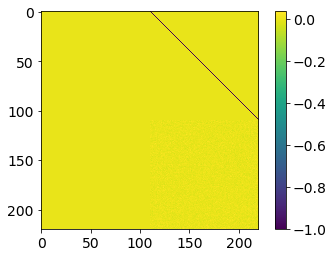

In [82]:
plt.imshow(theta)
plt.colorbar()

In [83]:
net.w_rec

array([[-0.0031981 , -0.00825497, -0.02296329, ..., -0.00253727,
        -0.00255193,  0.00567198],
       [ 0.01609347,  0.00658028, -0.00195445, ...,  0.01681165,
         0.00739666, -0.01172064],
       [ 0.00370329,  0.00071924, -0.01091053, ...,  0.00520427,
         0.00748975, -0.02083032],
       ...,
       [-0.00878579, -0.00096175, -0.00138472, ..., -0.00441277,
         0.00400456, -0.00022652],
       [ 0.01277618, -0.00319116, -0.00025859, ..., -0.01434209,
         0.01045916,  0.00443295],
       [-0.00626832, -0.00176658,  0.00779437, ...,  0.00696173,
        -0.01264063, -0.01797104]])

In [40]:
(net.w_in @ task1.x_in[t_ind]).shape

(200,)

In [21]:
a = (-1 + np.exp(net.w_rec * t)) @ LA.pinv2(net.w_rec) @ (net.w_in @ task1.x_in[t_ind].squeeze())
a.shape

(50,)

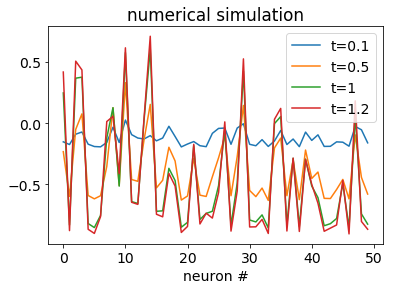

In [294]:
for t in [0.1,0.5,1,1.2]:
    
    steps = np.arange(0,task1.trial_duration)
    
    assert t < task1.trial_duration*net.dt, 'time must be less than trial duration'
    assert np.around(t/net.dt,decimals=10) in steps, 'time must be a multiple of net.dt'

    t_ind = np.where(np.around(t/net.dt,decimals=10)==steps)[0][0]

    av_activity = np.mean(np.asarray(sim.session_probes['h']),axis=0).squeeze()
    activity = av_activity[t_ind,:]
    activity_std = np.std(np.asarray(sim.session_probes['h']),axis=0).squeeze()[t_ind,:]
    
    plt.plot(activity,label='t={}'.format(t))
    


plt.legend()
plt.title('numerical simulation')
plt.xlabel('neuron #')
plt.show()

In [264]:

theta_11 = np.zeros(net.w_rec.shape)
theta_12 = -np.eye(net.w_rec.shape[0],net.w_rec.shape[1])
theta_21 = -net.w_fb @ net.w_out # (neurons,neurons)
theta_22 = -net.w_rec # (neurons,neurons)

# stack four matrices
# final matrix should be shape (2*neurons,2*neurons)
theta_A = np.concatenate((theta_11, theta_12), axis=1)
theta_A.shape

(50, 100)

In [167]:
activity.shape

(1000, 20, 50, 1)

In [251]:
(net.w_in @ task1.x_in.T).shape

(50, 200)

In [282]:
LA.pinv2(0*net.w_fb @ net.w_out)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [75]:
np.linalg.cond(net.w_fb @ net.w_out)

1.0285184564006205e+19

In [76]:
np.finfo((net.w_fb @ net.w_out).dtype).eps

2.220446049250313e-16

In [148]:
t=1.9
steps = np.arange(0,task1.trial_duration)
    
assert np.round(t/net.dt,decimals=10) in steps, 'time must be a multiple of dt'

np.where(np.round(t/net.dt,decimals=10)==steps)[0][0]

19

In [280]:
LA.pinv2(0*net.w_fb @ net.w_out)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [136]:
np.around(1.9/0.1,decimals=10)

19.0

In [113]:
steps

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [33]:
a = np.linalg.inv(net.w_fb @ net.w_out) @ (net.w_in @ task1.x_in.T)
a[1].shape

(20,)

In [23]:
np.linalg.inv(net.w_fb @ net.w_out).shape

(50, 50)

In [25]:
task1.x_in.shape

(20, 4)

In [30]:
a = net.w_in @ task1.x_in.T
a.shape

(50, 20)

In [35]:
a = net.w_fb @ net.w_out
a.shape

(50, 50)

In [37]:
np.zeros(net.w_rec.shape).shape

(50, 50)

In [39]:
np.eye(net.w_rec.shape[0],net.w_rec.shape[1])

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [46]:
t = 10
mu_1 = np.linalg.inv(net.w_fb @ net.w_out) @ (net.w_in @ task1.x_in.T) # (neurons, timesteps)
mu_2 = np.zeros(mu_1.shape)
    
mu = np.concatenate((mu_1[:,t],mu_2[:,t]),axis=0)
mu.shape

(100,)

In [43]:
theta_11 = np.zeros(net.w_rec.shape)
theta_12 = -np.eye(net.w_rec.shape[0],net.w_rec.shape[1])
theta_21 = -net.w_fb @ net.w_out # (neurons,neurons)
theta_22 = -net.w_rec # (neurons,neurons)

# stack four matrices here
theta_A = np.concatenate((theta_11, theta_12), axis=1)
theta_B = np.concatenate((theta_21, theta_22), axis=1)
theta = np.concatenate((theta_A,theta_B),axis=0)

In [44]:
theta.shape

(100, 100)